# Importing the libraries

In [1]:
import os

import pandas as pd
import numpy as np
import math
import itertools

import h5py

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam


import matplotlib.pyplot as plt
import seaborn as sns

## Auxiliary functions

#### Plotting functions

In [2]:
## Loss function
def plot_loss(history, type):

    loss = history.history.history['loss']
    val_loss = history.history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure()
    plt.semilogy(epochs, loss, 'b', label='Training')
    plt.semilogy(epochs, val_loss, 'r', label='Validation')
    plt.xlabel('Epoch [-]')
    plt.ylabel('Loss [-]')
    plt.grid()
    plt.legend()
    plt.savefig('Plots/Loss_' + type + '.pdf', format='pdf', bbox_inches='tight')

## Accuracy function
def plot_acc(history, type):
    acc = history.history.history['accuracy']
    val_acc = history.history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, 'b', label= 'Training')
    plt.plot(epochs, val_acc, 'r', label= 'Validation')
    plt.xlabel('Epoch [-]')
    plt.ylabel('Accuracy [%]')
    plt.grid()
    plt.legend()
    plt.savefig('Plots/Acc_' + type + '.pdf',format = 'pdf', bbox_inches = 'tight')

## Confusion Matrix for the training set
def plot_CM_train(history, type, X_train, y_train):

    TrainPredictions = history.predict(X_train)
    TrainPredictions = np.argmax(TrainPredictions, axis=1)
    train_labels = np.argmax(y_train, axis=1)


    print('\nAccuracy in the training set: {:.4f}\n'.format(accuracy_score(train_labels, TrainPredictions)))

    conf = confusion_matrix(train_labels, TrainPredictions)

    classes = [0, 1]
    # plot confusion matrix
    plt.figure()
    plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title("Train Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = conf.max() / 2.
    for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
        plt.text(j, i, format(conf[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if conf[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('Plots/CM_train_'+type+'.pdf',format = 'pdf', bbox_inches = 'tight')

## Confusion Matrix for the test set
def plot_CM_test(history, type, X_test, y_test):

    TestPredictions = history.predict(X_test)
    TestPredictions = np.argmax(TestPredictions, axis=1)
    test_labels = np.argmax(y_test, axis=1)
    print('\nAccuracy in the test set: {:.4f}\n'.format(accuracy_score(test_labels, TestPredictions)))

    conf = confusion_matrix(test_labels, TestPredictions)

    classes = [0, 1]
    # plot confusion matrix
    plt.figure()
    plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title("Test Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = conf.max() / 2.
    for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
        plt.text(j, i, format(conf[i, j], fmt),
                horizontalalignment="center",
                color="white" if conf[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('Plots/CM_test_'+type+'.pdf',format = 'pdf', bbox_inches = 'tight')


#### Neural Network Architecture ####

In [27]:
def NN(X_train, X_val,y_train, y_val, type, lr, epochs, patience, batch_size):

    if type == 'Logistic':

        input_shape = X_train.shape[1:]
    
        model = tf.keras.Sequential()
        model.add(keras.layers.Dense(2, input_shape = input_shape, activation='sigmoid'))


    elif type == 'Shallow':

        input_shape = X_train.shape[1:]

        model = tf.keras.Sequential()
        model.add(keras.layers.Dense(1000, input_shape = input_shape, activation='tanh'))
        model.add(keras.layers.Dense(2, activation='sigmoid'))


    elif type == 'Deep':

        input_shape = X_train.shape[1:]

        model = tf.keras.Sequential()
        model.add(keras.layers.Dense(1000, input_shape = input_shape, activation='tanh'))
        model.add(keras.layers.Dense(100, input_shape = input_shape, activation='tanh'))
        model.add(keras.layers.Dense(10, activation='tanh'))
        model.add(keras.layers.Dense(2, activation='sigmoid'))


    elif type == 'CNN':
        
        input_shape = X_train.shape[1:]

        model = tf.keras.Sequential()
        model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation="tanh", input_shape = input_shape))
        model.add(keras.layers.MaxPool2D(pool_size=(2,2)))
        model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), activation="tanh"))
        model.add(keras.layers.MaxPool2D(pool_size=(2,2)))
        model.add(keras.layers.Conv2D(128, kernel_size=(3, 3), activation="tanh"))
        model.add(keras.layers.MaxPool2D(pool_size=(2,2)))
        model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), activation="tanh"))
        model.add(keras.layers.MaxPool2D(pool_size=(2,2)))
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dropout(0.5))
        model.add(keras.layers.Dense(2, activation='sigmoid'))

        model.build(input_shape)
    else:
        print('Error: Type of NN not found')
        return

        

    model.compile(
                  optimizer=Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'],
                 )

    model.summary()

    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

    model.fit(X_train, y_train, 
              validation_data = (X_val, y_val), 
              epochs=epochs, 
              batch_size=batch_size, 
              verbose = 0,
              callbacks=[early_stop]
              )

    return model


#### Parameters Evaluation   

In [28]:
def evaluation(X_train, X_val, X_test, y_train, y_val, y_test,type, lr  = 0.001, epochs = 2000, patience = 250, batch_size = 64):

    if type == 'CNN':
        ## Converting the train set
        X_tr = X_train

        ## Converting the validation set 
        X_v = X_val

        ## Converting the test set 
        X_te = X_test

    elif type =='Logistic' or type =='Shallow' or type =='Deep':
        ## Converting the train set
        X_tr = X_train.reshape(-1,64*64*3)

        ## Converting the validation set 
        X_v = X_val.reshape(-1,64*64*3)

        ## Converting the test set 
        X_te = X_test.reshape(-1,64*64*3)

    ## Building and Training the model 
    model = NN(X_tr, X_v, y_train, y_val, type, lr, epochs, patience, batch_size)

    ## Plotting the loss function
    plot_loss(model, type)

    ## Plotting the accuracy
    plot_acc(model, type)

    ## Plotting the confusion matrix for the train set
    plot_CM_train(model, type , X_tr, y_train)

    ## Plotting the confusion matrix for the test set
    plot_CM_test(model,type, X_te, y_test)

## Reading the data

In [29]:
IMAGE_SIZE = 256
IMAGE_DIRECTORY = 'Data/'#'./gdrive/MyDrive/Jupyter Programs/Datasets/'

In [30]:
filename = 'train_catvnoncat.h5'
f = h5py.File(IMAGE_DIRECTORY+filename, 'r')

In [31]:
data_train = list(f['train_set_x'])
data_label = list(f['train_set_y'])

In [32]:
X_tr=np.array(data_train)
y_tr= np.array(data_label)

In [33]:
filename = 'test_catvnoncat.h5'
f = h5py.File(IMAGE_DIRECTORY+filename, 'r')

In [34]:
data_test = list(f['test_set_x'])
data_label_test = list(f['test_set_y'])

In [35]:
X_test=np.array(data_test)
y_test= np.array(data_label_test)

# Plotting some examples

(64, 64, 3)


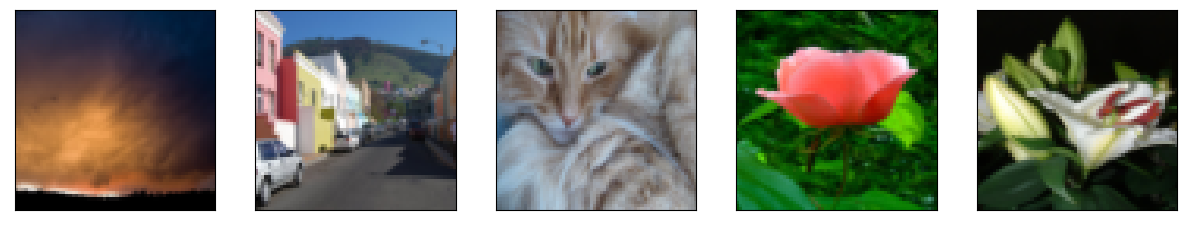

In [61]:
print(data_train[1].shape)
n=5
plt.figure(figsize=(15, 15))
for i in range(n):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(data_train[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Data Balancing

c:\Users\Guilherme\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


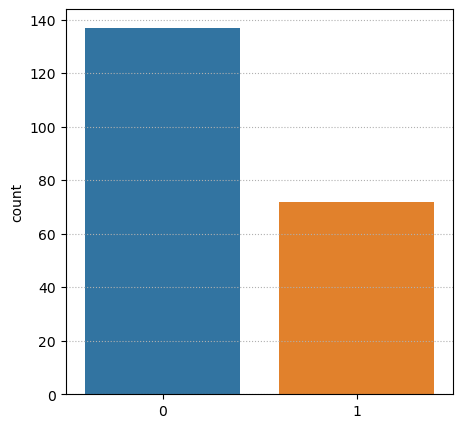

In [80]:
fig = plt.figure(figsize=(5, 5))
plt.grid(linestyle=':')
sns.countplot(y_tr)
plt.savefig('Plots/Countplot.pdf',format = 'pdf', bbox_inches = 'tight')

## Training and Validation sets splits

In [74]:
X_train,X_val,y_train,y_val = train_test_split(X_tr,y_tr,test_size = 0.1, stratify = y_tr, random_state = 42)
print('Shape of train set feature',X_train.shape)
print('Shape of validation set feature',X_val.shape)
print('Shape of train set label',y_train.shape)
print('Shape of validation set label',y_val.shape)

num_classes=2
input_shape = (64,64,3)

y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

Shape of train set feature (188, 64, 64, 3)
Shape of validation set feature (21, 64, 64, 3)
Shape of train set label (188,)
Shape of validation set label (21,)


## Evaluation of the Architectures

#### Logistic Regression

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 2)                 24578     
                                                                 
Total params: 24,578
Trainable params: 24,578
Non-trainable params: 0
_________________________________________________________________
6/6 [==============================] - 0s 2ms/step

Accuracy in the training set: 1.0000

2/2 [==============================] - 0s 2ms/step

Accuracy in the test set: 0.6000



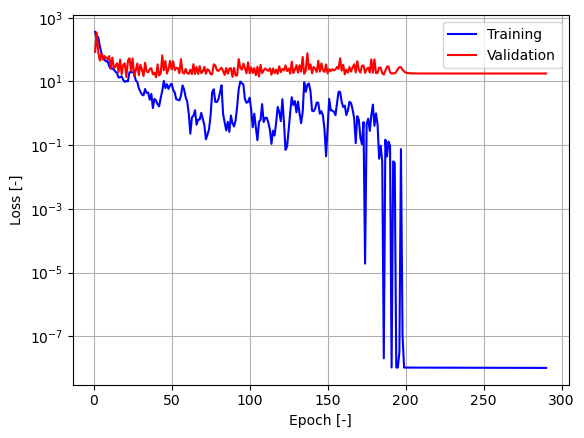

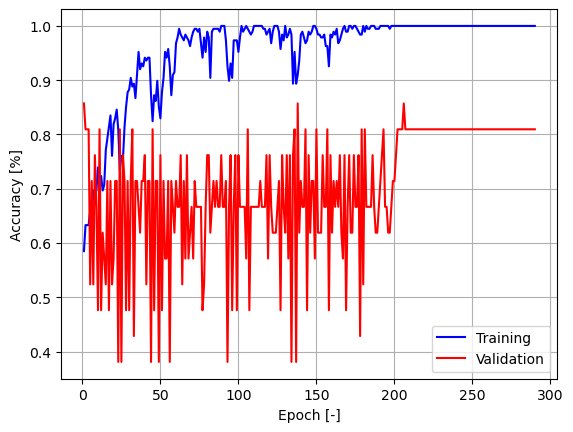

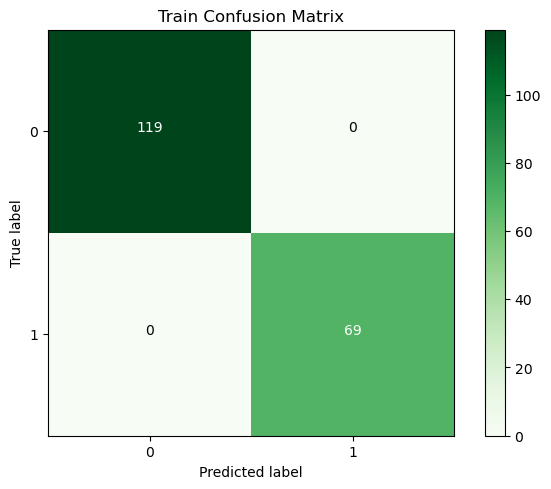

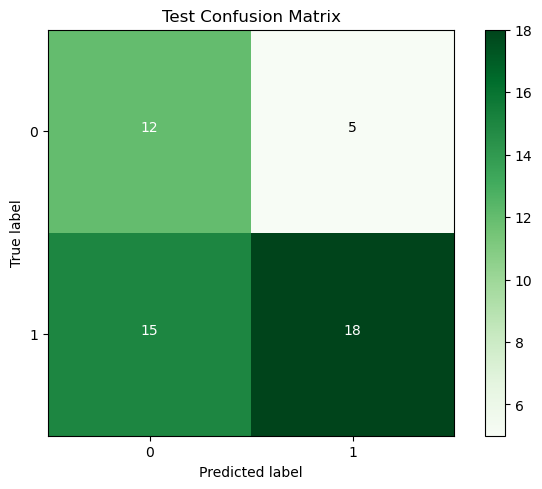

In [38]:
evaluation(X_train, X_val, X_test, y_train, y_val, y_test, 'Logistic')

#### Shallow Neural Network

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1000)              12289000  
                                                                 
 dense_4 (Dense)             (None, 2)                 2002      
                                                                 
Total params: 12,291,002
Trainable params: 12,291,002
Non-trainable params: 0
_________________________________________________________________
6/6 [==============================] - 0s 9ms/step

Accuracy in the training set: 0.6649

2/2 [==============================] - 0s 7ms/step

Accuracy in the test set: 0.3600



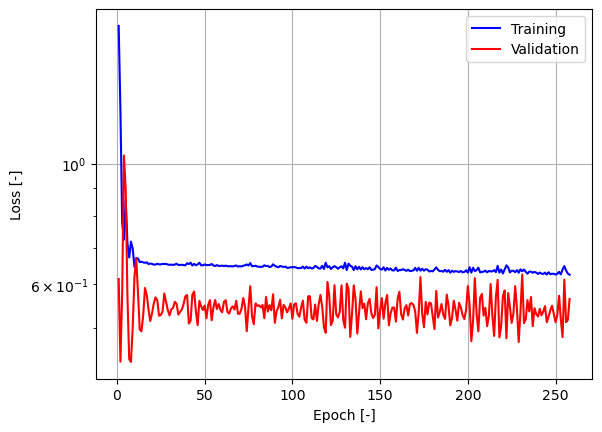

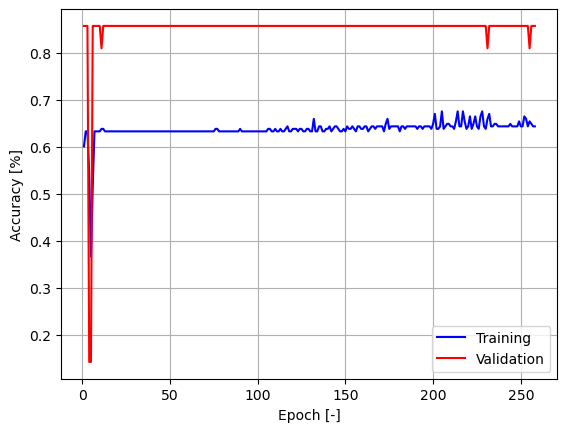

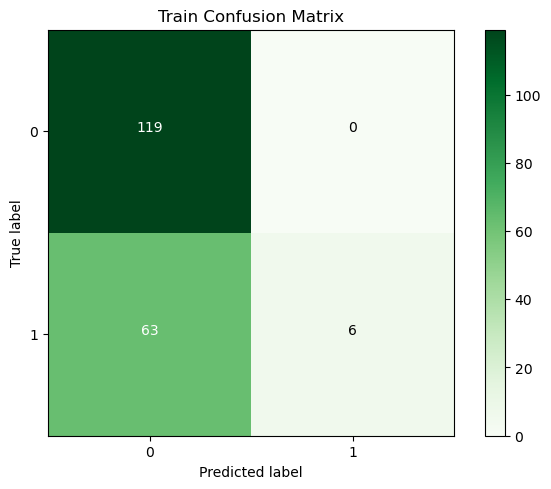

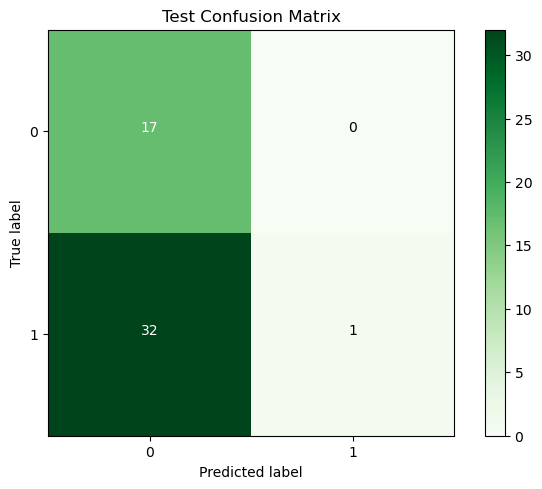

In [39]:
evaluation(X_train, X_val, X_test, y_train, y_val, y_test,'Shallow')

#### Deep Neural Network

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1000)              12289000  
                                                                 
 dense_6 (Dense)             (None, 100)               100100    
                                                                 
 dense_7 (Dense)             (None, 10)                1010      
                                                                 
 dense_8 (Dense)             (None, 2)                 22        
                                                                 
Total params: 12,390,132
Trainable params: 12,390,132
Non-trainable params: 0
_________________________________________________________________
6/6 [==============================] - 0s 9ms/step

Accuracy in the training set: 0.6330

2/2 [==============================] - 0s 7ms/step

Accuracy in the test set: 0.3400

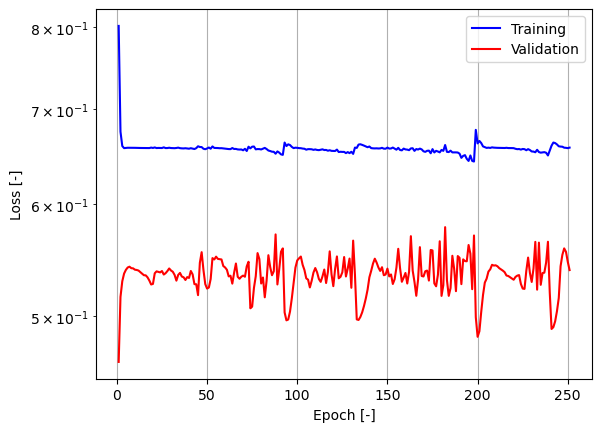

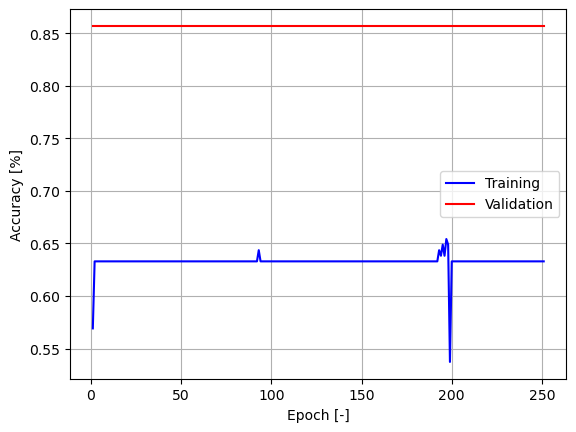

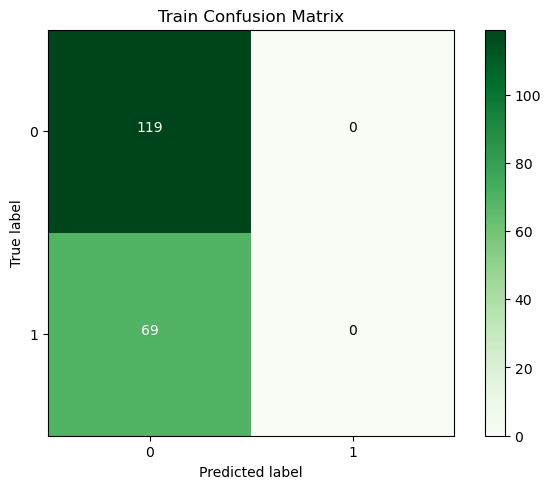

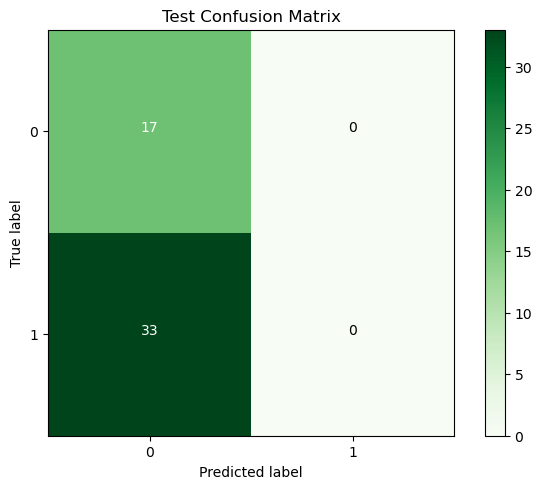

In [40]:
evaluation(X_train, X_val, X_test, y_train, y_val, y_test,'Deep')

#### Convolutional Neural Network

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)       

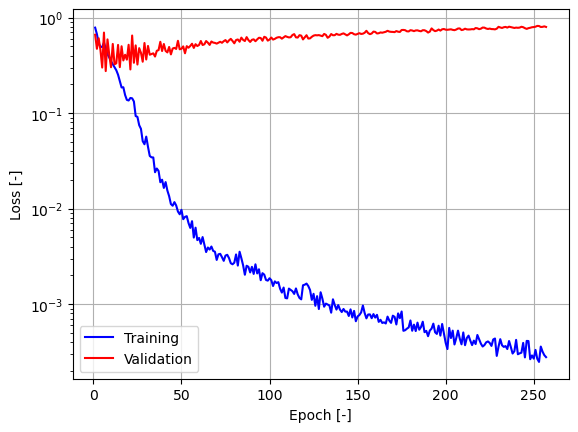

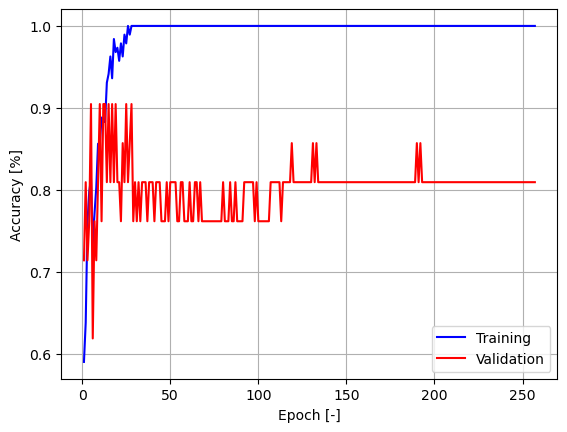

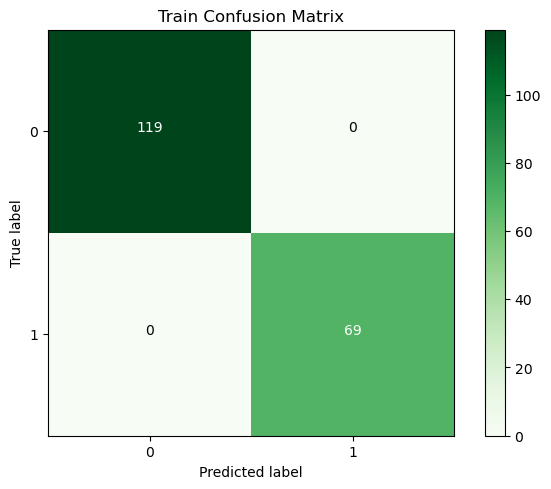

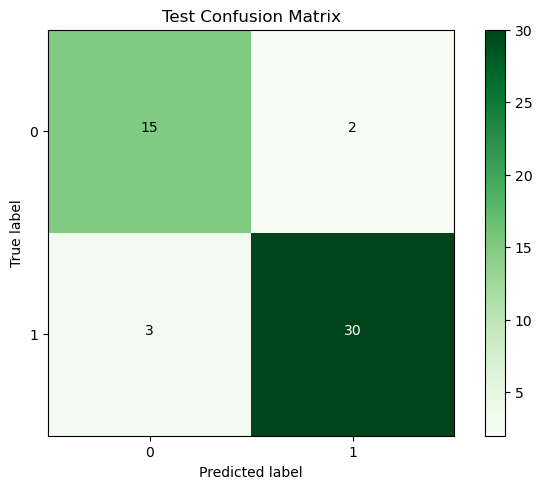

In [41]:
evaluation(X_train, X_val, X_test, y_train, y_val, y_test,'CNN')